In [1]:
import pandas as pd
import DataLoading
import NN_classes
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w_ext_o_dummy/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.4
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"],"LB")
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

input_f_sc01_Network_Existing_Generation_Full_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_109_N_112_cac1_2030.csv
86
input_f_sc01_N

In [3]:
def calculate_lb_from_dfs_out(dfs_out,execution): 
    return (dfs_out["Network_Existing_Generation_Full"].sum(axis=1) - dfs_out[execution].sum(axis=1))

def calculate_lb_from_ts_out(ts_out,ex):
    b= "Network_Existing_Generation_Full"
    all_ts_out_ex = torch.concat((ts_out["train"][ex],ts_out["test"][ex],ts_out["val"][ex]))
    all_ts_out_benchmark = torch.concat((ts_out["train"][b],ts_out["test"][b],ts_out["val"][b]))
    return all_ts_out_benchmark-all_ts_out_ex
    

def find_xthbest_model_params_from_df(df_losses,loss_to_sort,xth_best=1):
    return df_losses.sort_values(by =loss_to_sort)[xth_best-1:xth_best]

def create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run = True):
    #First, extract params from row
    model_type = row.Model_type.item()
    model_type = tuple(map(int, model_type.replace("(","").replace(")","").split(', ')))
    dor_text = dor = row.Dor.item()
    lr = row.Lr.item()
    nb_e = row.Epochs.item()

    relu_out = row.Relu_out.item()
    np =row.Np.item()
    bs = row.Batch_size.item()
    alpha = row.alpha.item()
    MAE = row.MAE.item()
    
    if str(alpha) == "0.0": 
        alpha = "0"
    if str(dor) == "0.0": 
        dor_text = "0"

    if row.Min_val.item(): 
        mt = "min_val"
    else: 
        mt = "all_epochs"
    
    #Then create model of given type
    m = NN_classes.create_model(model_type,input_size, dropout_ratio= dor,relu_out =relu_out,inter=True,inter_size=inter_size)
    
    #Finally, extract model state from dict
    
    #m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro_{bs}bs"
    m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor_text}dor_{np}np_{relu_out}ro_{bs}bs_{alpha}ill_{MAE}MAE"

    if cluster_run:
        #m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro_{bs}bs"
        path = f"ResultsClusterRuns/trained_models/{hyperloop_name}/{mt}/model_{m_name}.pth"
    else:
        path = f"trained_models/{hyperloop_name}/{mt}/model_{m_name}.pth"

    m.load_state_dict(torch.load(path))
    m.eval()
    
    return m

In [4]:
hyperloop_name = "RTS24_AC_12w_dummy_0.3_v0.4_PF_LB_0_40"
#df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
df_losses = pd.read_csv(f"ResultsClusterRuns/Loss_results_csv/{hyperloop_name}.csv",index_col=0)

[172, 258, 62, 38, 19, 9]


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


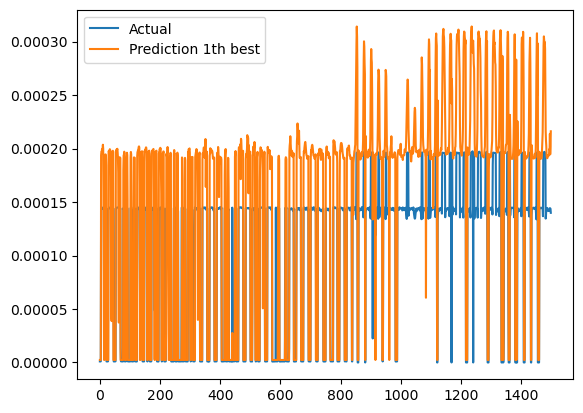

In [54]:
#Visualisation of multiple models in input order

cluster_run = True
f = df_losses.Np == 0
loss_to_sort = "Te_l_t_mse"

ex = all_executions[2]

ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()

s = 0
e=s+1500
plt.plot(ex_out[s:e],label = "Actual")

for xth_best in [1]: 
    row = find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=cluster_run)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

In [52]:
i=0
all_counts = pd.DataFrame()

for ex in all_executions:
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
    lb_actual = dfs_out[ex].sum(axis=1).to_numpy().flatten()
    
    lb_est =  m(ex_in.float())[0].detach().numpy().flatten()
    
    both_positive_count = np.sum((lb_est > 0) & (lb_actual > 0))
    both_negative_count = np.sum((lb_est < 0) & (lb_actual < 0))
    opposite_sign_count = np.sum((lb_est * lb_actual) < 0)
    BZ = np.sum((lb_est==0) & (lb_actual == 0))
    OZ = np.sum((lb_est * lb_actual) == 0)


    row_lb = pd.DataFrame({"exec":ex,"BP":both_positive_count, "BN":both_negative_count,"OS":opposite_sign_count,"OZ":OZ,"BZ":BZ,}, index = [i])
    all_counts = pd.concat([all_counts,row_lb],axis=0)
    i+=1
    

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.recipro

In [53]:
all_counts.sum()

exec    Network_Existing_Generation_FullNetwork_Line_I...
BP                                                  76341
BN                                                      0
OS                                                   8738
OZ                                                   2281
BZ                                                      0
dtype: object

In [43]:
#calculate loss manually to see if coherent 

data_part = "test"
loss = torch.nn.MSELoss()

prediction = m(d_ft_in[data_part].float())[0]
loss(prediction.squeeze(),d_ft_out[data_part])

tensor(5.7853e-09, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [44]:
manual_loss_mse = np.mean([(p.item()-a)**2  for p,a in zip(prediction.squeeze(),d_ft_out[data_part])])
manual_loss_mae = np.mean(np.abs([(p.item()-a)  for p,a in zip(prediction.squeeze(),d_ft_out[data_part])]))

In [45]:
manual_loss_mse,manual_loss_mae

(5.785276570340915e-09, 5.5119475880945136e-05)

In [22]:
prediction.squeeze()

tensor([1.1114e-04, 1.1932e-04, 1.1292e-04,  ..., 2.3428e-06, 2.9865e-04,
        3.4909e-04], grad_fn=<SqueezeBackward0>)